In [1]:
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import loader, torch, torchvision

from torchvision import transforms
from PIL import Image, ImageDraw

from DeepStar.Model import DeepStar
from Dijkstra import *

In [2]:
img_size = (256, 256)
save_file = "deep_star"
seed = 0

In [3]:
torch.manual_seed(seed)

net = DeepStar()
#net.load_state_dict(torch.load(save_file))

In [4]:
to_tensor = transforms.ToTensor()

def guess_to_point(g, img_size):
    return (round(g[0][0].item() * img_size[0]), round(g[0][1].item() * img_size[0]))

def guess_point(net, img, img_size):
    img_tensor = to_tensor(img).unsqueeze(0)
    #input_tensor = torch.tensor([[(0, 0), (1, 1)], img_tensor])
    return guess_to_point(net([[(0, 0), (1, 1)], img_tensor]), img_size)


## Test Loaded Network

In [5]:
x, y = (184, 170)

with Image.open(f'{x}_{y}_confirm.png') as img:
    gx, gy = guess_point(net, img, img_size)

    print(gx, gy)

12 -28


In [6]:
def add_point(img, point, color_space):
    x, y = point
    img.paste(color_space, (x - 1, y - 1, x, y))
    
def add_points(img, start, end):
    sx, sy = start
    ex, ey = end
    
    img.paste((0, 255, 0), (sx - 1, sy - 1, sx, sy))
    img.paste((0, 0, 255), (ex - 1, ey - 1, ex, ey))
    
def get_midpoints(net, img_path, path):
    new_path = []
    
    for i in range(len(path) - 1):
        with Image.open(img_path) as img:
            add_points(img, path[i], path[i + 1])
            
            g = guess_point(net, img, img_size)
            new_path.append(g)
            
    return_path = []
    for i in range(len(path)):
        return_path.append(path[i])
        
        if (i < len(new_path)):
            return_path.append(new_path[i])
    
    return return_path

0
1
2
3


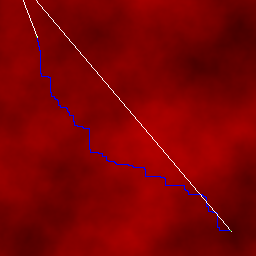

In [9]:
m = "map.png"
start = (37, 37)
end = (231, 231)

#(146, 145)
#(163, 164)

path = [start, end]

for i in range(4):
    print(i)
    path = get_midpoints(net, m, path)

#print(len(path))
with Image.open(m) as img:
    world = []
    pixels = img.load()
    for x in range(256):
        world.append([])
        for y in range(256):
            world[x].append(Node(pixels[x, y][0] / 255, (x, y)))
    
    edges = get_edges(world)
    dijkstra_path = dijkstra1(edges, start, end)
    for d in get_path(dijkstra_path):
        #print(d)
        add_point(img, d, (0, 0, 255))
    
    draw = ImageDraw.Draw(img)
    draw.line(path)
    
    del draw
    for p in path:
        add_point(img, p, (0, 255, 0))
    
    display(img)